In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='aef0d83e09420ab62e46dcc847d07af6eefa7ad9')
TLT = pdr.get_data_tiingo('TLT', api_key='aef0d83e09420ab62e46dcc847d07af6eefa7ad9')
GLD = pdr.get_data_tiingo('GLD', api_key='aef0d83e09420ab62e46dcc847d07af6eefa7ad9')
SPY.reset_index(inplace=True)
TLT.reset_index(inplace=True)
GLD.reset_index(inplace=True)


/Users/abnerteng/opt/miniconda3/lib/python3.8/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)
/Users/abnerteng/opt/miniconda3/lib/python3.8/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)
/Users/abnerteng/opt/miniconda3/lib/python3.8/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [23]:
Close = pd.concat([SPY.adjClose, TLT.adjClose, GLD.adjClose], axis = 1)
Close.index = SPY.date
Close.columns = ['SPY', 'TLT', 'GLD']
cov_matrix = Close.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix
expected_return = Close.resample('Y').last()[:-1].pct_change().mean()
expected_return
standard_dev = Close.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
standard_dev
return_dev_matrix = pd.concat([expected_return, standard_dev], axis = 1)
return_dev_matrix.columns = ['Exp Returns', 'Standard Dev.']
return_dev_matrix



,Exp Returns,Standard Dev.
SPY,0.184455,0.203908
TLT,0.065157,0.149380
GLD,0.091451,0.137967


In [24]:
port_ret = []
port_dev = []
port_weights = []
assets_nums = 3
port_nums = 2000

for port in range(2000):
    weights = np.random.random(assets_nums)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    returns = np.dot(weights, expected_return)
    port_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    port_dev.append(ann_sd)
    
data = {'Returns': port_ret, 'Standard Dev.': port_dev}

for counter, symbol in enumerate(Close.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]
    
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Standard Dev.,SPY weight,TLT weight,GLD weight
0,0.103350,0.095914,0.297832,0.600933,0.101235
1,0.109913,0.091117,0.319443,0.427776,0.252781
2,0.100112,0.092399,0.225865,0.469502,0.304633
3,0.085352,0.106408,0.059504,0.442444,0.498052
4,0.137118,0.120283,0.511001,0.070676,0.418323


(array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

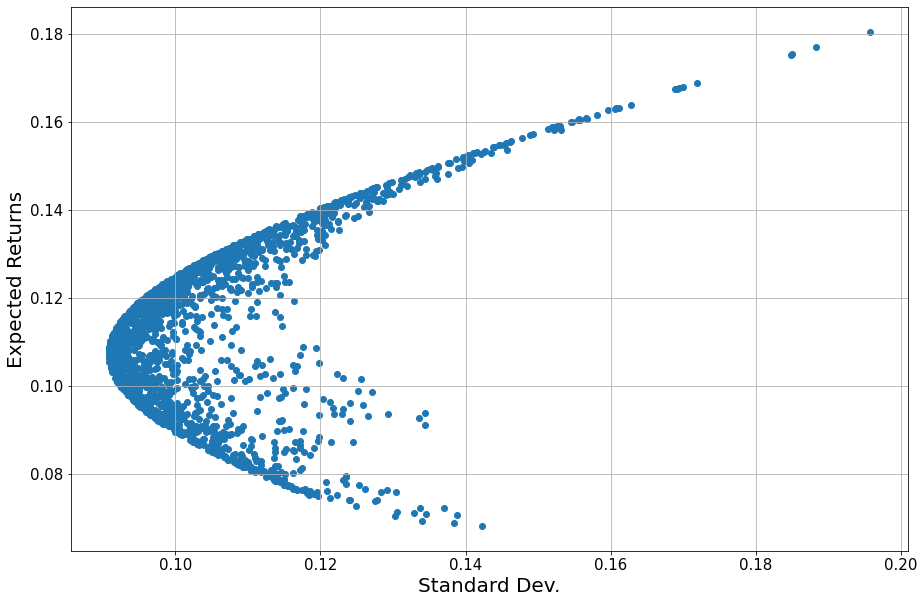

In [25]:
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


In [26]:
std = []
ret = [portfolios[portfolios['Standard Dev.'] == portfolios['Standard Dev.'].min()]['Returns'].values[0]]
eff_front_set = pd.DataFrame(columns=['Returns', 'Standard Dev.', 'SPY weight', 'TLT weight', 'GLD weight'])
for i in range(800,1800,1):
    df = portfolios[(portfolios['Standard Dev.'] >= i/10000) & (portfolios['Standard Dev.'] <= (i+15)/10000)]
    try:
        # 上側
        max_ret = df[df['Returns'] == df['Returns'].max()]['Returns'].values[0]
        if max_ret >= max(ret):
            std.append(df[df['Returns'] == df['Returns'].max()]['Standard Dev.'].values[0])
            ret.append(df[df['Returns'] == df['Returns'].max()]['Returns'].values[0])
            eff_front_set = eff_front_set.append(df[df['Returns'] == df['Returns'].max()], ignore_index = True)
    except:
        pass

ret.pop(0)
eff_front_std = pd.Series(std)
eff_front_ret = pd.Series(ret)

/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_53164/1272591258.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eff_front_set = eff_front_set.append(df[df['Returns'] == df['Returns'].max()], ignore_index = True)


(array([0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

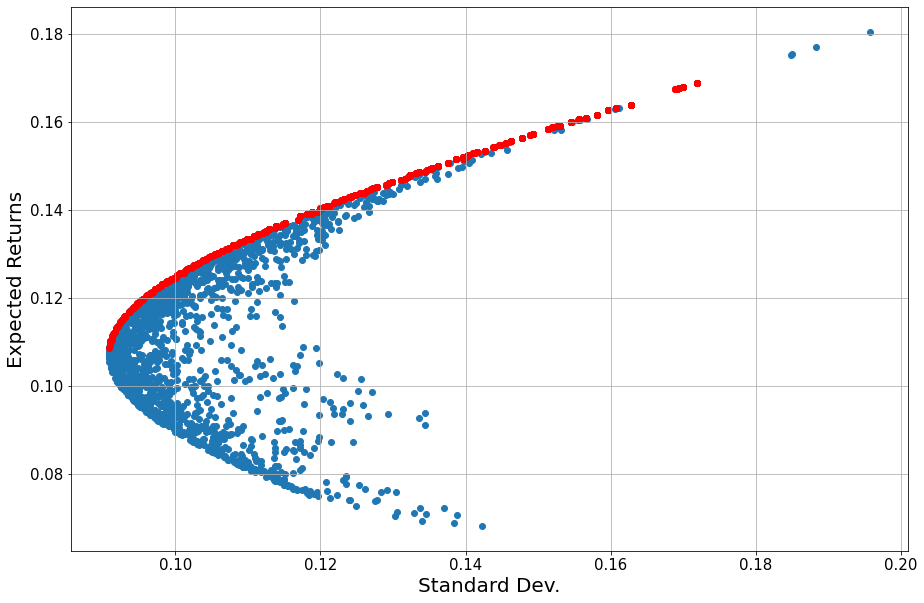

In [27]:
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
# 效率前緣點，用紅色標註
plt.scatter(x = eff_front_std, y = eff_front_ret, c = 'r')
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [28]:
eff_front_set

,Returns,Standard Dev.,SPY weight,TLT weight,GLD weight
0,0.10858,0.090885,0.302623,0.418964,0.278412
1,0.109391,0.090969,0.30903,0.410789,0.280182
2,0.110108,0.091083,0.314495,0.402865,0.28264
3,0.110108,0.091083,0.314495,0.402865,0.28264
4,0.11053,0.09128,0.326785,0.430262,0.242954
...,...,...,...,...,...
753,0.168977,0.171923,0.851549,0.063587,0.084864
754,0.168977,0.171923,0.851549,0.063587,0.084864
755,0.168977,0.171923,0.851549,0.063587,0.084864
756,0.168977,0.171923,0.851549,0.063587,0.084864


In [30]:
max_sharpe = 0
max_sharpe_returns = 0
max_sharpe_std = 0
for i in range(len(eff_front_set)):
    sharpe = ( eff_front_set.iloc[i,:]['Returns'] - 0.007 ) / eff_front_set.iloc[i,:]['Standard Dev.']
    if sharpe > max_sharpe:
        max_sharpe = sharpe
        max_sharpe_std = eff_front_set.iloc[i,:]['Standard Dev.']
        max_sharpe_returns = eff_front_set.iloc[i,:]['Returns']
        max_sharpe_set = (eff_front_set.iloc[i,:]['SPY weight'], eff_front_set.iloc[i,:]['TLT weight'], eff_front_set.iloc[i,:]['GLD weight'])
print("sharpe ratio最大點的報酬率與標準差 ", "(Returns, Standard Dev.) =", (max_sharpe_returns, max_sharpe_std))
print("sharpe ratio最大點的投組", "(SPY weight, TLT weight, GLD weight) =", max_sharpe_set)

sharpe ratio最大點的報酬率與標準差  (Returns, Standard Dev.) = (0.12196551964934911, 0.09726646966949405)
sharpe ratio最大點的投組 (SPY weight, TLT weight, GLD weight) = (0.4224334253648561, 0.33367566585611197, 0.243890908779032)
